In [ ]:
##### PART 1: Loading data, doing all pre-processing and whatnot ######
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
scaler = StandardScaler()
path=r"/Users/kai/Documents/BSE/Term 3/Advanced Time Series – Nowcasting & Forecasting/Homework 2/Compiled data set.xlsx"
data = pd.read_excel(path, header=0, index_col=0, parse_dates=True)
data.sort_values('Date', inplace=True)

# Reshuffling dataframe columns to how i want them to read: GDP, hard indicators, soft indicators
data = data[['GDP', 'Industrial Production', 'Retail Sales', 'Employment', 'Exports', 'Imports', 'Electricity Consumption', 'Manufacturing PMI', 'Services PMI', 'Consumer Confidence']]
data = data.iloc[:-11,:]
data.tail(10)

,GDP,Industrial Production,Retail Sales,Employment,Exports,Imports,Electricity Consumption,Manufacturing PMI,Services PMI,Consumer Confidence
Date,,,,,,,,,,
2022-08-01,99999.0,50528.3,5.1,75.0,41030.0,57941.0,21.0174,47.3,50.9,-38.50
2022-09-01,99999.0,53765.1,3.9,75.0,41008.0,55531.0,20.8494,48.4,50.0,-43.50
2022-10-01,645805.0,53326.8,5.3,75.2,41071.0,50716.0,22.3846,46.2,48.8,-41.00
2022-11-01,99999.0,56177.6,3.7,75.2,40616.0,53111.0,23.6292,46.5,48.8,-37.25
2022-12-01,99999.0,51400.5,2.7,75.2,37582.0,54800.0,25.6560,45.3,49.9,-36.00
2023-01-01,657793.0,50234.9,4.0,75.2,34408.0,50994.0,25.5265,47.0,48.7,-38.00
2023-02-01,99999.0,51407.6,5.0,75.3,33718.0,50377.0,23.3434,49.3,53.5,-31.00
2023-03-01,99999.0,60445.7,3.1,75.4,33355.0,50167.0,24.1400,47.9,52.9,-30.00
2023-04-01,673914.0,50161.1,4.2,75.5,33555.0,48237.0,21.6245,47.8,55.9,-24.00


In [ ]:
## (1.1) Seasonally adjusting electricity consumption data

#I'm just defining electricity consumption as X for readability
X = data['Electricity Consumption'].values

# Calculating change from the same month but the previous year
months_in_yr = 12
elec_diff = [None] * 12 #have to do this to assign 12 NA's so data is same length as our df
for i in range(months_in_yr, len(X)):
    value = X[i] - X[i - months_in_yr]
    elec_diff.append(value)

data['Electricity SA'] = elec_diff # SA for seasonally adjusted
data = data[data.index > '2009-12-01'] #removing the first 12 months of data as they are NA

# Dropping the original electricity consumption column (we now have seasonally adjusted version)
data.drop('Electricity Consumption', axis=1, inplace=True)
data.head()

,GDP,Industrial Production,Retail Sales,Employment,Exports,Imports,Manufacturing PMI,Services PMI,Consumer Confidence,Electricity SA
Date,,,,,,,,,,
2010-01-01,396113.0,31582.3,0.4,70.3,19618.0,27752.0,54.5,54.5,-8.2,0.2815
2010-02-01,99999.0,34316.2,4.2,70.2,21749.0,27422.0,58.4,58.4,-7.0,-1.1891
2010-03-01,99999.0,42937.7,3.9,70.2,21572.0,29824.0,56.5,56.5,-8.0,2.6219
2010-04-01,401311.0,37338.3,3.9,70.4,21942.0,29378.0,55.3,55.3,-8.9,1.7539
2010-05-01,99999.0,36914.0,4.1,70.4,21658.0,29586.0,55.4,55.4,-11.1,-0.6381


/var/folders/4x/mvrhm6ks0ql5m2wsdb_v91sh0000gn/T/ipykernel_40677/2536963108.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(pad=20)


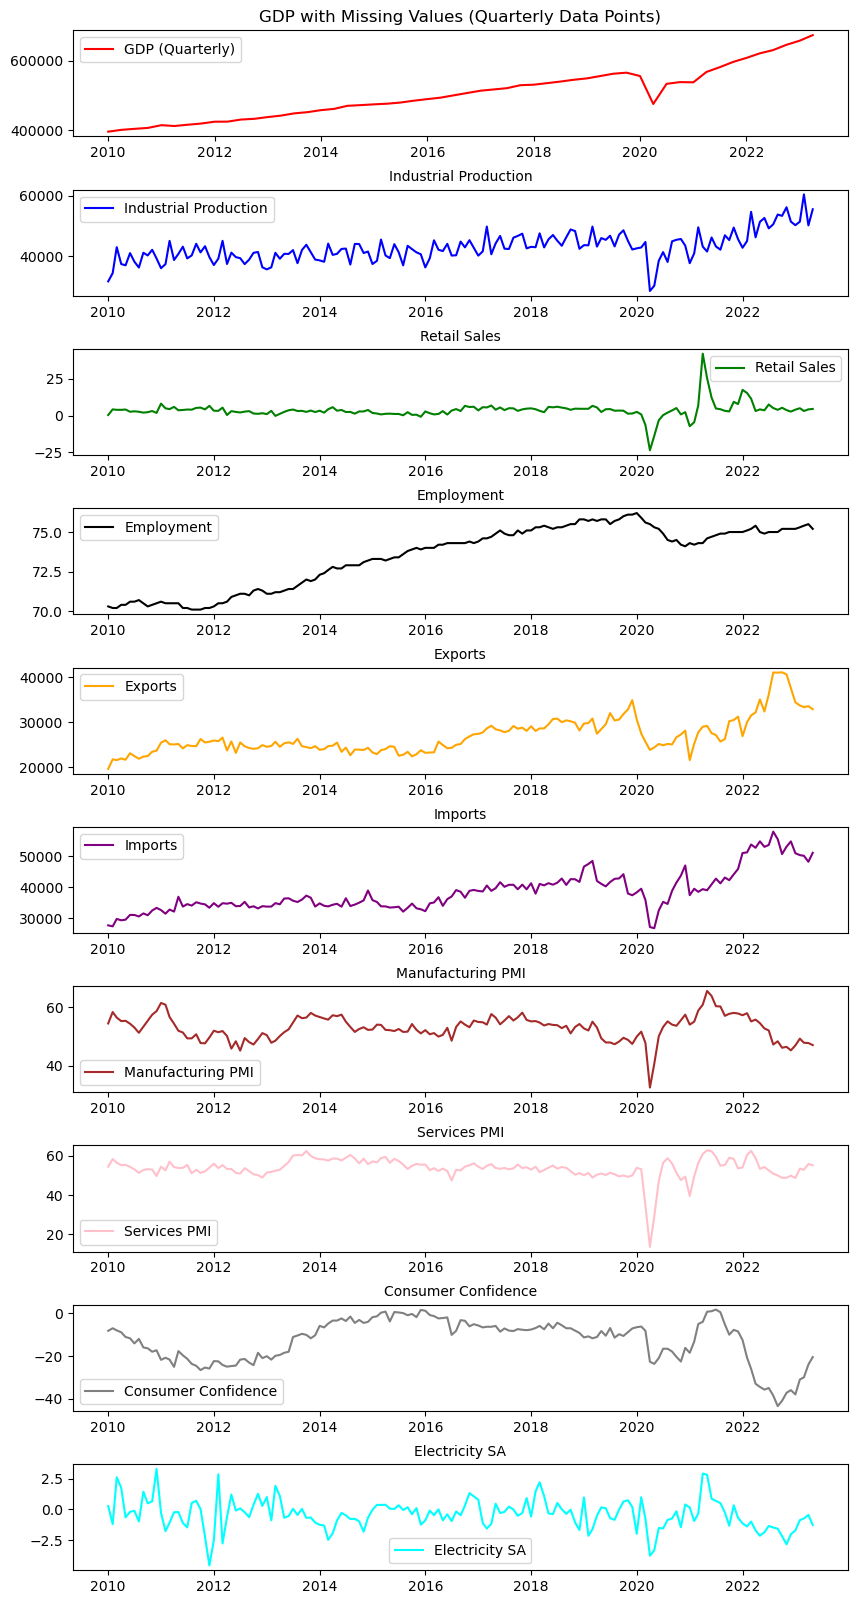

In [ ]:
## (1.2) Plotting all variables to assess stationarity of the various series
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))  # Adjust figsize as needed
fig.subplots_adjust(hspace=0.5)

colors = ['red', 'blue', 'green', 'black', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow']

for i, column in enumerate(data.columns):
    if i == 0:  # Only for the first column (GDP)
        gdp_quarterly = data[column].iloc[::3]  # Select every 3rd value
        axes[i].plot(gdp_quarterly.index, gdp_quarterly, label='GDP (Quarterly)', color='red')
        axes[i].set_title('GDP with Missing Values (Quarterly Data Points)')
    else:
        axes[i].plot(data[column], label=column, color=colors[i])
        axes[i].set_title(column, fontsize=10)
    axes[i].legend()

plt.tight_layout(pad=20)
plt.show()

In [ ]:
## (1.3)
# Taking log-differences of GDP
data['GDP'] = data['GDP'].replace(99999, np.nan)  #replacing 99999s with NAs temporarily to avoid any accidental stuff of taking logs of 99999 etc.
data['GDP'] = np.log(data['GDP']).diff(3)  #calculating log difference over three periods (skipping over missings)
#data['GDP_log_diff'].fillna(9999, inplace=True)  #putting 99999s back

data.head(10)  # Quick check again
# Note: Retail sales is already in annualised return form so we skip
data['Industrial Production'] = np.log(data['Industrial Production']).diff()
data['Exports'] = np.log(data['Exports']).diff()
data['Imports'] = np.log(data['Imports']).diff()
data['Employment'] = np.log(data['Employment']).diff()
data['Manufacturing PMI'] = np.log(data['Manufacturing PMI']).diff()
data['Services PMI'] = np.log(data['Services PMI']).diff()
data['Consumer Confidence'] = (data['Consumer Confidence']).diff()


# Reshuffling dataframe again:
data = data[['GDP', 'Industrial Production', 'Retail Sales', 'Employment', 'Exports', 'Imports', 'Manufacturing PMI', 'Services PMI', 'Consumer Confidence', 'Electricity SA']]
data.head(10) #quick check again

,GDP,Industrial Production,Retail Sales,Employment,Exports,Imports,Manufacturing PMI,Services PMI,Consumer Confidence,Electricity SA
Date,,,,,,,,,,
2010-01-01,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.2815
2010-02-01,NaN,0.083021,4.2,-0.001423,0.103120,-0.011962,0.069115,0.069115,1.2,-1.1891
2010-03-01,NaN,0.224133,3.9,0.000000,-0.008172,0.083968,-0.033075,-0.033075,-1.0,2.6219
2010-04-01,0.013037,-0.139731,3.9,0.002845,0.017006,-0.015067,-0.021468,-0.021468,-0.9,1.7539
2010-05-01,NaN,-0.011429,4.1,0.000000,-0.013028,0.007055,0.001807,0.001807,-2.2,-0.6381
2010-06-01,NaN,0.104103,2.6,0.002837,0.064241,0.050421,-0.018215,-0.018215,-0.6,-0.1900
2010-07-01,0.007171,-0.071913,2.9,0.000000,-0.028014,-0.000868,-0.024187,-0.024187,-2.4,-0.1054
2010-08-01,NaN,-0.052449,2.6,0.001415,-0.025938,-0.015593,-0.034486,-0.034486,2.1,-0.9726
2010-09-01,NaN,0.127508,2.0,-0.002833,0.020983,0.031579,0.040120,0.028820,-4.0,1.4474


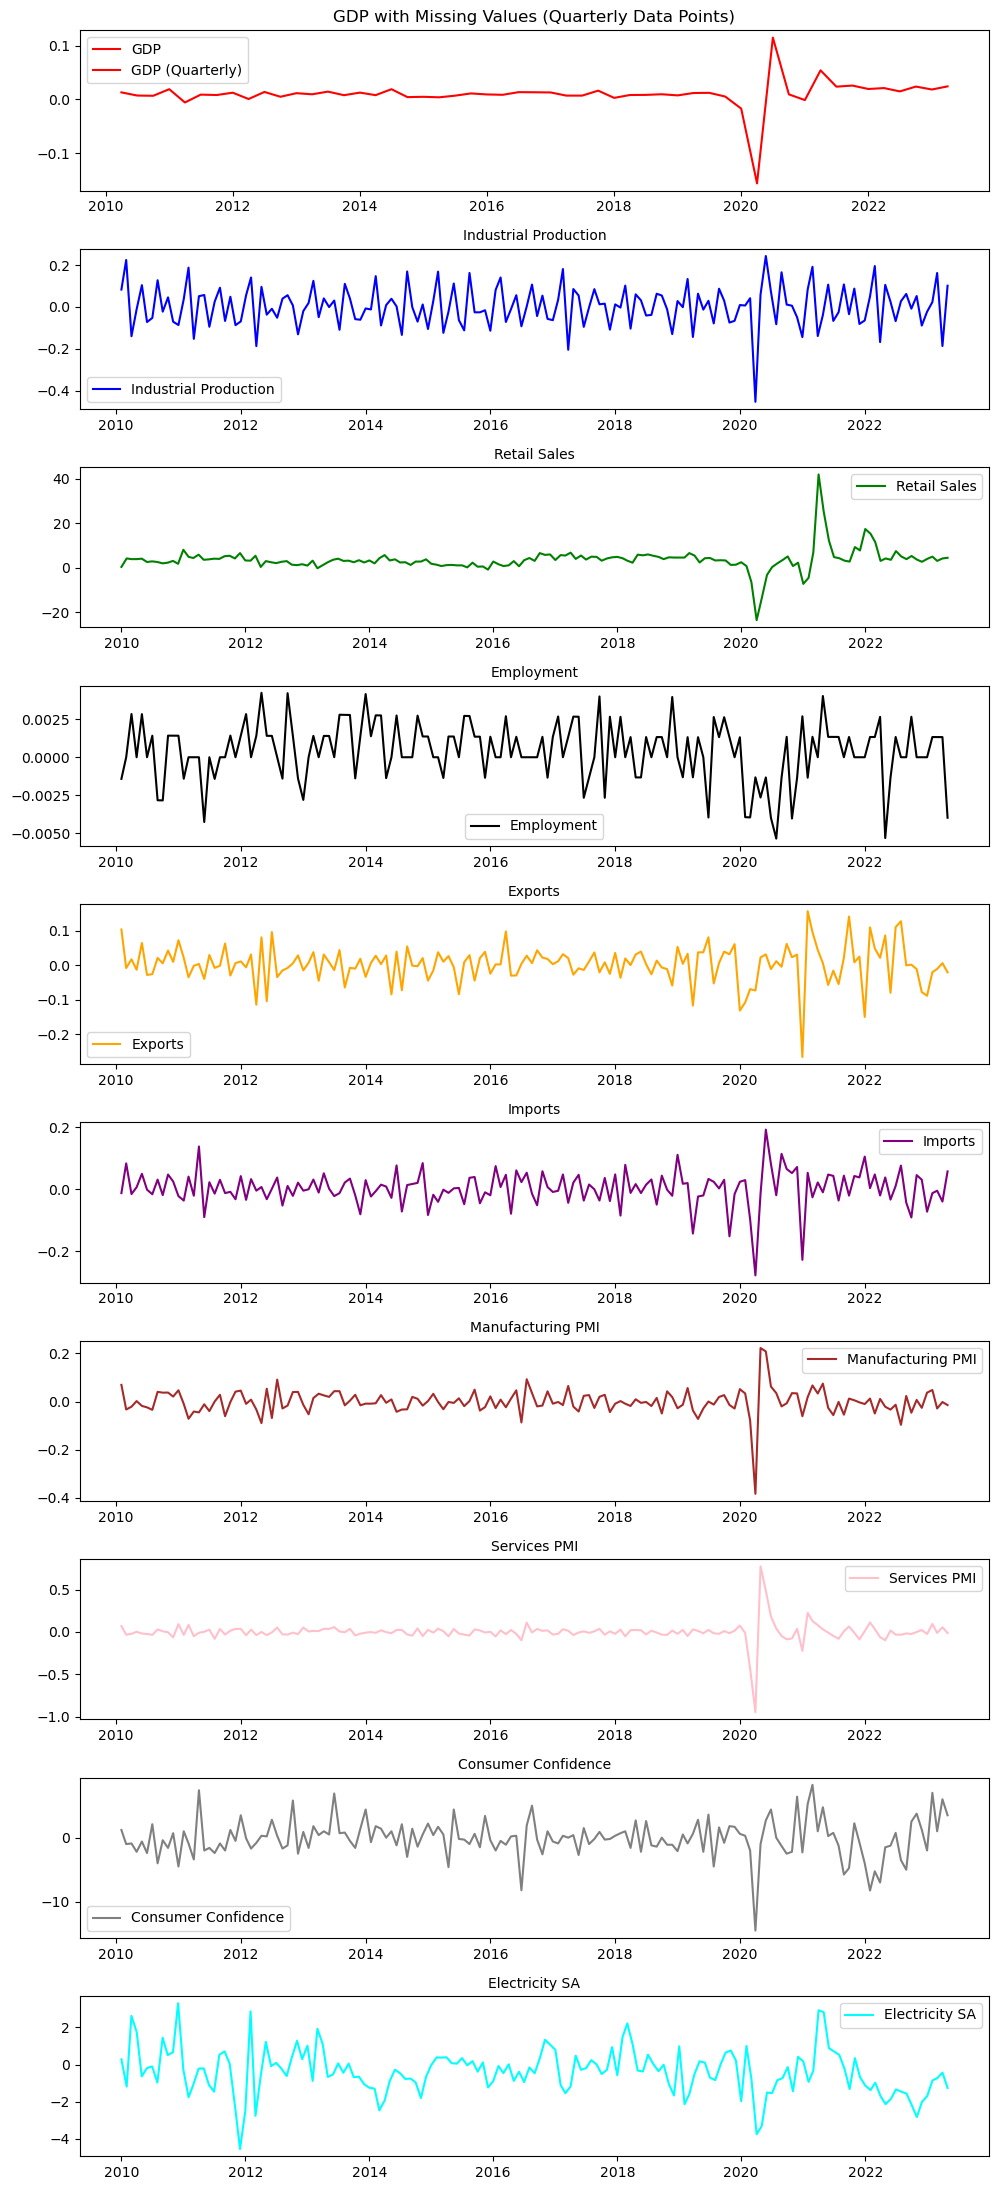

In [ ]:
## (1.4)
# Plotting all variables again to see if now stationary
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 22))  # Adjust figsize as needed
fig.subplots_adjust(hspace=0.5)

columns_to_plot = list(data.columns[0:])  # Adjust this to plot only the variables you want to see
colors = ['red', 'blue', 'green', 'black', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow']

for i, column in enumerate(columns_to_plot):
    axes[i].plot(data[column], label=column, color=colors[i])
    axes[i].set_title(column, fontsize=10)
    axes[i].legend()

gdp_quarterly = data['GDP'].iloc[::3]  # Select every 3rd value
# Plotting GDP with missing values (quarterly data points)
axes[0].plot(gdp_quarterly.index, gdp_quarterly, label='GDP (Quarterly)', color='red')
axes[0].set_title('GDP with Missing Values (Quarterly Data Points)')
axes[0].legend()

plt.tight_layout()
plt.show()

# 2. Load data, create the index of NAs, standardise it, and fill missing values with random values


In [ ]:
data = data

# Create boolean index for valid data
index = ~data.isna()

# Calculating means and std deviations for each variable (column) without counting NAs (we use this later for forecasting)
means = []
std_devs = []

for i in range(data.shape[1]):
    non_na_data = data.iloc[:, i].dropna()  # Filter out NAs
    means.append(non_na_data.mean())
    std_devs.append(non_na_data.std())

print("Means:", means)
print("Standard Deviations:", std_devs)

# Standardising the data
def standardise(df):
    standardised_data = df.copy()
    for column in df.columns:
        valid_data = df[column][df[column].notna()]
        mean = valid_data.mean()
        std = valid_data.std()
        standardised_data[column] = (df[column] - mean) / std
    return standardised_data

data_standardised = standardise(data)

# Filling missing values with random values
def fill_missing(data, va=1):
    filled_data = data.copy()
    for column in data.columns:
        missing_count = filled_data[column].isna().sum()
        if missing_count > 0:
            filled_data.loc[filled_data[column].isna(), column] = np.random.randn(missing_count) * va
    return filled_data

data_filled = fill_missing(data_standardised)
yv = data_filled #just matching notation with Gabriel

yv.tail(10) #check to see if things look reasonable

Means: [0.010026471363165325, 0.003524891004902797, 3.611801242236025, 0.0004211214508698435, 0.0032264659977638056, 0.003818291150786979, -0.0009120481290426641, 7.97640725865717e-05, -0.076875, -0.3761329192546584]
Standard Deviations: [0.028912399549922956, 0.09722686930159188, 5.1561659554603585, 0.0019180169216417213, 0.05387681798477574, 0.0562176899327843, 0.05274675140029179, 0.12020571639273943, 2.973028057945861, 1.2194322917230993]


,GDP,Industrial Production,Retail Sales,Employment,Exports,Imports,Manufacturing PMI,Services PMI,Consumer Confidence,Electricity SA
Date,,,,,,,,,,
2022-08-01,-1.886768,0.242009,0.288625,-0.219561,2.297088,1.302082,-1.815137,-0.273972,-1.151393,-0.891781
2022-09-01,-0.829946,0.602365,0.055894,-0.219561,-0.069841,-0.823622,0.453138,-0.149075,-1.655930,-0.975427
2022-10-01,0.478654,-0.120444,0.327414,1.168914,-0.031393,-1.681291,-0.864659,-0.202756,0.866751,-1.472954
2022-11-01,-1.938441,0.499391,0.017105,-0.219561,-0.266658,0.752865,0.140000,-0.000664,1.287198,-2.015665
2022-12-01,-0.713673,-0.950304,-0.176837,-0.219561,-1.500893,0.488954,-0.478385,0.184774,0.446304,-1.343139
2023-01-01,0.289364,-0.272176,0.075288,-0.219561,-1.697624,-1.348339,0.715734,-0.203166,-0.646857,-1.085724
2023-02-01,-0.571545,0.201088,0.269231,0.473292,-0.435878,-0.284458,0.923062,0.781351,2.380359,-0.396223
2023-03-01,0.120609,1.629534,-0.099260,0.472373,-0.260791,-0.142225,-0.528877,-0.094489,0.362215,-0.293552
2023-04-01,0.490646,-1.954506,0.114077,0.471456,0.051074,-0.765762,-0.022330,0.458225,2.044002,-0.053276


# 3. Make our `build_matrices` function based on our model's requirements ######


In [ ]:
def build_matrices(startvals):
    # Ensure startvals is a 1x32 vector
    if len(startvals) != 42:
        raise ValueError('startvals must be a 1x42 vector.')

    # Initialize R
    R = np.ones((10,10 ))  # nxn matrix

    # Extract gamma coefficients
    gamma = startvals[:10]

    # Construct h01 (the first row of H matrix)
    gdp_vector = np.array([1/3, 2/3, 1, 2/3, 1/3])  # Creating the coeff vales for GDP
    h0 = np.concatenate((gdp_vector * gamma[0], np.zeros(7) ,gdp_vector, np.zeros(18))) #row for GDP
    h1 = np.concatenate(([gamma[1]], np.zeros(11), np.zeros(5), [1], np.zeros(17)))    # 1x35 row. So we have gdp numbers * gamma_GDP, then we have 7 zeros, then gdp numbers (to multiply error terms), then 15 zeros at the end: 5+7+5+18=35
    h2 = np.concatenate(([gamma[2]], np.zeros(11), np.zeros(7), [1], np.zeros(15)))  # 1x35 row
    h3 = np.concatenate(([gamma[3]], np.zeros(11), np.zeros(9), [1], np.zeros(13)))  # 1x35 row
    h4 = np.concatenate(([gamma[4]], np.zeros(11), np.zeros(11), [1], np.zeros(11))) # 1x35 row
    h5 = np.concatenate(([gamma[5]], np.zeros(11), np.zeros(13), [1], np.zeros(9)))  # 1x35 row
    h6 = np.concatenate(([gamma[6]], np.zeros(11), np.zeros(15), [1], np.zeros(7)))  # 1x35 row
    h7 = np.concatenate(([gamma[7]], np.zeros(11), np.zeros(17), [1], np.zeros(5)))  # 1x35 row
    h8 = np.concatenate(([gamma[8]], np.zeros(11), np.zeros(19), [1], np.zeros(3)))  # 1x35 row
    h9 = np.concatenate(([gamma[9]], np.zeros(11), np.zeros(21), [1], np.zeros(1)))  # 1x35 row

    # Stack all rows to form the H matrix
    H = np.vstack((h0, h1, h2, h3, h4, h5, h6, h7, h8, h9))  # 10x35 matrix

    # Extracting phi coefficients
    phi = startvals[10:32] # Getting next 22 coefficients from startvals

    # Allocating some of the phi coefficients for readability
    phi_Factor = phi[:2]
    phi_GDP = phi[2:4]

    # Build F matrix
    # Create first 12 rows (factor and it's 11 lags)
    f0 = np.concatenate((phi_Factor, np.zeros(33)))  # First row for phi_1 and phi_2
    f1 = np.concatenate(([1], np.zeros(34)))  # Second row for factor lags
    f2 = np.concatenate(([0, 1], np.zeros(33)))  # Third row for factor lags
    f3 = np.concatenate(([0, 0, 1], np.zeros(32)))
    f4 = np.concatenate(([0, 0, 0, 1], np.zeros(31)))
    f5 = np.concatenate(([0, 0, 0, 0, 1], np.zeros(30)))
    f6 = np.concatenate(([0, 0, 0, 0, 0, 1], np.zeros(29)))
    f7 = np.concatenate(([0, 0, 0, 0, 0, 0, 1], np.zeros(28)))
    f8 = np.concatenate(([0, 0, 0, 0, 0, 0, 0, 1], np.zeros(27)))
    f9 = np.concatenate(([0, 0, 0, 0, 0, 0, 0, 0, 1], np.zeros(26)))
    f10 = np.concatenate(([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], np.zeros(25)))
    f11 = np.concatenate(([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], np.zeros(24)))

    # Create next 5 rows (GDP error term and lagged error terms)
    f12 = np.concatenate((np.zeros(12), phi_GDP, np.zeros(21))) # GDP error term
    f13 = np.concatenate((np.zeros(12), [1], np.zeros(22))) # GDP error term lag (t-1)
    f14 = np.concatenate((np.zeros(13), [1], np.zeros(21))) # GDP error term lag (t-2)
    f15 = np.concatenate((np.zeros(14), [1], np.zeros(20))) # GDP error term lag (t-3)
    f16 = np.concatenate((np.zeros(15), [1], np.zeros(19))) # GDP error term lag (t-4)

    # Create next 18 rows (error terms and lagged error terms)
    f17 = np.concatenate((np.zeros(12), np.zeros(5), phi[4:6], np.zeros(16)))    # e_1,t
    f18 = np.concatenate((np.zeros(12), np.zeros(5), [1], np.zeros(17)))           # e_1,t-1
    f19 = np.concatenate((np.zeros(12), np.zeros(7), phi[6:8], np.zeros(14)))    # e_2,t
    f20 = np.concatenate((np.zeros(12), np.zeros(7), [1], np.zeros(15)))           # e_2,t-1
    f21 = np.concatenate((np.zeros(12), np.zeros(9), phi[8:10], np.zeros(12)))   # e_3,t
    f22 = np.concatenate((np.zeros(12), np.zeros(9), [1], np.zeros(13)))           # e_3,t-1
    f23 = np.concatenate((np.zeros(12), np.zeros(11), phi[10:12], np.zeros(10))) # e_4,t
    f24 = np.concatenate((np.zeros(12), np.zeros(11), [1], np.zeros(11)))          # e_4,t-1
    f25 = np.concatenate((np.zeros(12), np.zeros(13), phi[12:14], np.zeros(8)))  # e_5,t
    f26 = np.concatenate((np.zeros(12), np.zeros(13), [1], np.zeros(9)))           # e_5,t-1
    f27 = np.concatenate((np.zeros(12), np.zeros(15), phi[14:16], np.zeros(6)))  # e_6,t
    f28 = np.concatenate((np.zeros(12), np.zeros(15), [1], np.zeros(7)))           # e_6,t-1
    f29 = np.concatenate((np.zeros(12), np.zeros(17), phi[16:18], np.zeros(4)))  # e_7,t
    f30 = np.concatenate((np.zeros(12), np.zeros(17), [1], np.zeros(5)))           # e_7,t-1
    f31 = np.concatenate((np.zeros(12), np.zeros(19), phi[18:20], np.zeros(2)))  # e_8,t
    f32 = np.concatenate((np.zeros(12), np.zeros(19), [1], np.zeros(3)))           # e_8,t-1
    f33 = np.concatenate((np.zeros(12), np.zeros(21), phi[20:22]))               # e_9,t
    f34 = np.concatenate((np.zeros(12), np.zeros(21), [1], np.zeros(1)))           # e_9,t-1 

    F = np.vstack((f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17, f18, f19, f20, f21, f22, f23, f24, f25, f26, f27, f28, f29, f30, f31, f32, f33, f34))  # 35x35 matrix

    ## Constructing Q matrix ##
    var_of_factor_error_term = 1 
    error_coeffs = startvals[32:]     # So, error_coeffs is a 10x1 vector, and error_coeffs[0] is the GDP error term
     
     # Making the last matrix in our big transition eqn.
    z2 = np.concatenate((
        [var_of_factor_error_term], 
        np.zeros(11), 
        [error_coeffs[0]], np.zeros(4), 
        [error_coeffs[1]], [0], 
        [error_coeffs[2]], [0], 
        [error_coeffs[3]], [0], 
        [error_coeffs[4]], [0], 
        [error_coeffs[5]], [0], 
        [error_coeffs[6]], [0], 
        [error_coeffs[7]], [0], 
        [error_coeffs[8]], [0], 
        [error_coeffs[9]], [0]
    ))
    z2 = z2 ** 2
    Q = np.diag(z2)  # should be 10x10 matrix
# checking matrices look OK.
    # print('R:')
    # print(R)
    # print('H:')
    # print(H)
    # print('F:')
    # print(F)
    # print('Q:')
    # print(Q)

    return R, Q, H, F

In [ ]:
## (3.1) Testing with our initial values to make sure matrices are being constructed properly

# Defining initial values (using one's given in class and extrapolating)
startvals = [0.367, 0.497, 0.604, 0.430, 0.381, 0.497, 0.604, 0.430, 0.381, 0.35, \
             0.423, 0.255, 0.694, -0.576, 0.197, 0.521, -0.196, -0.159, -0.423, -0.222, -0.156, -0.003, 0.255, 0.694, -0.576, 0.197, 0.521, -0.196, -0.159, -0.423, -0.222, -0.156, \
             0.902219485, 0.860813569, 0.93434469, 0.900555384, 0.912688337, 0.902219485, 0.860813569, 0.93434469, 0.900555384, 0.912688337]

# Set the dimension n for the R matrix
n = 10  # Example size, adjust as needed

# Call the function with the defined vector `startvals`
R, Q, H, F = build_matrices(startvals)

# Display the results to verify
print('R:', R.shape)
print('H:', H.shape)
print('F:', F.shape)
print('Q:', Q.shape)

#print('H:', H)
#print('F:', F)

R: (10, 10)
H: (10, 35)
F: (35, 35)
Q: (35, 35)


# 4. Making our objective function using Kalman Filtering

In [ ]:
def ofn(startvals, yv, index):
    # Extract matrices from the parameter vector 'th'
    R, Q, H, F = build_matrices(startvals)

    # Initial states for the Kalman Filter
    beta00 = np.zeros((F.shape[0], 1)) 
    P00 = np.eye(F.shape[0])  # initialise state covariance matrix

    T = yv.shape[0]
    filter = np.zeros((T, F.shape[0]))  # initialise state estimates matrix
    like = np.zeros(T)  # initialise log-likelihood vector

    # Kalman filter iterations
    for it in range(T):
        valid_index = index.iloc[it, :].to_numpy()  # Get valid indices for the current time step

        if valid_index.any():  # will only process if there is at least one valid observation
            # Masking H matrix (setting rows to zero where observations are missing)
            H_it = H * valid_index[:, None]

            # Masking R matrix (setting diagonal elements to zero where observations are valid). Needs to be done for dimensions.
            R_it = np.diag((1 - valid_index) * np.diag(R))

            # Prediction step
            beta10 = np.dot(F, beta00)  #predict next state
            P10 = np.dot(np.dot(F, P00), F.T) + Q  #predict the next state covariance

            # Update step
            yv_it = yv.iloc[it, :].to_numpy().reshape(-1, 1)  #gets current observations

            n10 = yv_it - np.dot(H_it, beta10)  #innovation
            F10 = np.dot(np.dot(H_it, P10), H_it.T) + R_it  #innovation covariance

            # Check condition number
            cond_number = np.linalg.cond(F10)
            if cond_number > 1e12:
                print(f"High condition number at iteration {it}: {cond_number}")
                return np.inf

            # Compute log-likelihood
            try:
                F10_inv = np.linalg.inv(F10)
                log_det_F10 = np.log(np.linalg.det(F10))
                if not np.isfinite(log_det_F10):
                    print(f"Non-finite log determinant at iteration {it}")
                    return np.inf
            except np.linalg.LinAlgError:
                print(f"LinAlgError at iteration {it}")
                return np.inf  # this points the optimiser in the right direction

            like[it] = -0.5 * (log_det_F10 + np.dot(np.dot(n10.T, F10_inv), n10))

            K = np.dot(np.dot(P10, H_it.T), F10_inv) # Kalman gain

            # Update estimates
            beta11 = beta10 + np.dot(K, n10)  # update state estimate
            filter[it, :] = beta11.flatten()  # stores the state estimates correctly

            P11 = P10 - np.dot(np.dot(K, H_it), P10)  # Update state covariance

            # Roll over estimates to the next time step
            beta00 = beta11
            P00 = P11  # Prepare for the next time step with updated estimates
        else:
            print(f"Skipping iteration {it} due to no valid observations")
            if it > 0:  # Ensure we propagate previous state if there are no valid observations
                filter[it, :] = filter[it-1, :]

    # Sum negative log-likelihood
    fun = -np.sum(like)

    print(f"Final log-likelihood: {fun}")
    return fun, filter

# 5. Optimising using MLE

In [ ]:
# Defining the func to get the filter results
def get_filter_results(startvals, yv, index):
    return ofn(startvals, yv, index)[1] # (just takes filter results)

# Optimisation
def objective_fn(startvals):
    return ofn(startvals, yv, index)[0]  # Return only the objective function value for optimisation

# Set optimisation options
options = {
    'maxiter': 2000,          # No. of iterations
    'disp': False,          #can put on if you want to see iterations displayed
    'gtol': 1e-6,           # Tolerance for gradient
    'maxfun': 2000            # No. of function evaluations
}

## Minimising the objective function to get optimal parameters ##
res = minimize(objective_fn, startvals, method='L-BFGS-B', options=options)

# Check if hess_inv is returned correctly and is two-dimensional
if isinstance(res.hess_inv, np.ndarray):
    hessian_inv = res.hess_inv
else:
    hessian_inv = res.hess_inv.todense()  # Convert sparse matrix to dense if needed

# Calculate Cramer-Rao bound
try:
    cramerrao = np.linalg.inv(hessian_inv)
    std = np.sqrt(np.diag(cramerrao))
    print('optimised params and their std devs:')
    for param, std_dev in zip(res.x, std):
        print(f'Param: {param}, Std Dev: {std_dev}')
except np.linalg.LinAlgError:
    print("Can't invert Hessian - params may not be optimised.")

# Get the filter results from the optimized parameters
filter = get_filter_results(res.x, yv, index)

# Diagnostic prints
print("Transition Matrix F:\n", F)
print("Measurement Matrix H:\n", H)
print("Last State Estimate:\n", filter[-1, :])

Final log-likelihood: 972.3173942980816
Final log-likelihood: 972.317394416576
Final log-likelihood: 972.3173938535745
Final log-likelihood: 972.3173943512058
Final log-likelihood: 972.3173945317264
Final log-likelihood: 972.3173945415015
Final log-likelihood: 972.3173937482611
Final log-likelihood: 972.3173945532885
Final log-likelihood: 972.3173939296926
Final log-likelihood: 972.3173940820409
Final log-likelihood: 972.3173942369356
Final log-likelihood: 972.3173947472849
Final log-likelihood: 972.3173948754467
Final log-likelihood: 972.3173947285806
Final log-likelihood: 972.3173944532828
Final log-likelihood: 972.3173948192539
Final log-likelihood: 972.3173951882536
Final log-likelihood: 972.317393384811
Final log-likelihood: 972.317393834878
Final log-likelihood: 972.3173935735941
Final log-likelihood: 972.3173940277084
Final log-likelihood: 972.3173943011269
Final log-likelihood: 972.3173943027248
Final log-likelihood: 972.3173946972535
Final log-likelihood: 972.31739502659
Final

# 6. Forecasting

In [ ]:
# Forecast using the filter states
R, Q, H, F = build_matrices(res.x)
forecast = np.dot(H, filter.T).T

# Defining names to the means and standard deviations we calculated earlier for each variable in our data set:
mean_gdp = means[0]
sd_gdp = std_devs[0]

mean_indpro = means[1]
sd_indpro = std_devs[1]

mean_retail = means[2]
sd_retail = std_devs[2]

mean_emp = means[3]
sd_emp = std_devs[3]

mean_exp = means[4]
sd_exp = std_devs[4]

mean_imp = means[5]
sd_imp = std_devs[5]

mean_pmi_manufac = means[6]
sd_manuf = std_devs[6]

mean_pmi_services = means[7]
sd_pmi_services = std_devs[7]

mean_cons_conf = means[8]
sd_cons_conf = std_devs[8]

mean_electricity = means[9]
sd_electricity = std_devs[9]


# Forecasting:
# Get the last state estimate
last_state = filter[-1, :].reshape(-1, 1)

# Forecast the next 12 periods
num_periods = 12 #we forecast 12 months ahead
future_forecasts = np.zeros((num_periods, H.shape[0]))
#future_forecasts_adjusted = np.zeros((num_periods, H.shape[0]))

for i in range(num_periods):
    last_state = np.dot(F, last_state)  # Predict next state
    future_forecasts[i, :] = np.dot(H, last_state).flatten()
    
    #Adjusted forecast
    H2 = H.copy()
    H2[0, 5:10] = 0
    #future_forecasts_adjusted[i, :] = np.dot(H2, last_state).flatten()

# De-standardize the forecasts
gdp_forecast = future_forecasts[:, 0] * sd_gdp + mean_gdp
#gdp_forecast_adjusted = future_forecasts_adjusted[:, 0] * sd_gdp + mean_gdp

print("Forecasted GDP for next 5 periods:", gdp_forecast)
#print("Adjusted Forecasted GDP for next 12 months:", gdp_forecast_adjusted)

NameError: name 'res' is not defined

In [ ]:
def monthly_to_quarterly(monthly_forecasts):
    quarterly_forecasts = []
    for i in range(0, len(monthly_forecasts), 3):
        if i + 2 < len(monthly_forecasts):
            q_forecast = (monthly_forecasts[i] * monthly_forecasts[i + 1] * monthly_forecasts[i + 2]) ** (1 / 3)
            quarterly_forecasts.append(q_forecast)
    return np.array(quarterly_forecasts)

# Calculate quarterly GDP forecasts
quarterly_gdp_forecast = monthly_to_quarterly(gdp_forecast)

print("Forecasted GDP for next 4 quarters:", quarterly_gdp_forecast)

Forecasted GDP for next 4 quarters: [0.01558448 0.00841203 0.00993714 0.01048   ]


# 7. Plots

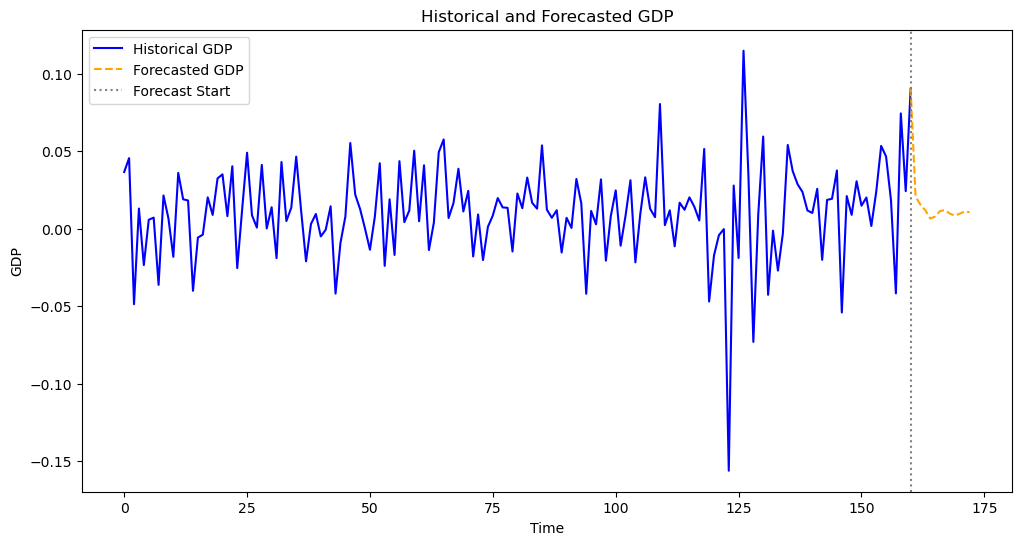

Forecasted GDP for next 12 periods: [0.02071172 0.01546543 0.01181679 0.00651602 0.00795453 0.01148435
 0.01195405 0.00969286 0.00846872 0.00972629 0.01112595 0.01063652]


In [ ]:
# Plot the historical GDP and forecasted GDP
plt.figure(figsize=(12, 6))

# Plot historical GDP
historical_gdp = yv.iloc[:, 0].dropna().values * sd_gdp + mean_gdp
plt.plot(np.arange(len(historical_gdp)), historical_gdp, label='Historical GDP', color='blue')

# Plot forecasted GDP
forecast_start = len(historical_gdp)
forecast_range = np.arange(forecast_start, forecast_start + len(gdp_forecast))

# Combine the last historical value with the forecast for a smooth transition
combined_gdp_forecast = np.concatenate(([historical_gdp[-1]], gdp_forecast))
forecast_range_combined = np.arange(forecast_start - 1, forecast_start + len(gdp_forecast))

plt.plot(forecast_range_combined, combined_gdp_forecast, label='Forecasted GDP', color='orange', linestyle='--')
plt.axvline(x=forecast_start - 1, color='gray', linestyle=':', label='Forecast Start') # vertical line to indicate start of forecast

# Labels and legend
plt.xlabel('Time')
plt.ylabel('GDP')
plt.title('Historical and Forecasted GDP')
plt.legend()

# Show the plot
plt.show()
print("Forecasted GDP for next 12 periods:", gdp_forecast)